<a href="https://colab.research.google.com/github/CarolineWeeLab/EZgut/blob/main/MaskPrediction_FluorescenceAnalysis_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

V1: mask predictions and fluorescence analysis now in same notebook
no checking of masks included
if visualise and find that masks has critical errors, download mask and draw ROIs in ImageJ -> replace in folder -> continue with fluorescence analysis

last edited by Jazlynn 14 January 2022

# Install packges

In [ ]:
# make sure to connect to GPU run time

!pip install pyyaml==5.1
# This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime


     |████████████████████████████████| 274 kB 12.1 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=0c3b0cc89665cb48859f4980b3315a15357536d2433af48ea92f045f039612c6
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 831.4 MB 1.2 MB/s eta 0:00:01

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Load data

In [ ]:
# mount drive and load data
# data should be google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Mask generation

Initialise predictor object, must ensure that model.weights has correct path

In [ ]:
# Obtain predictions and save masks

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("gut_train",)
cfg.DATASETS.TEST = ("gut_test")
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1200    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/gut_detection_data/model_final.pth"  # path to the model 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # minimum detection score for object to be considered
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5 # NMS for boxes with IOU > thresh
predictor = DefaultPredictor(cfg)

from detectron2.utils.visualizer import ColorMode

# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("gut_train", {}, "/content/drive/MyDrive/gut_detect_data/train.json", "/content/drive/MyDrive/gut_detect_data/train")
# no need these lines unless retrain model
gut_metadata = MetadataCatalog.get("gut_train_v3")

import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

To generate and save masks of the brightfield images. 
Directory is where BF images are stored. 
savedir is where output masks will be saved. 

In [ ]:
directory = "" # directory containing the brightfield images
# can copy as path from folder icon on left and choose correct folder

savedir = "" # directory to save predicted masks

for filename in os.listdir(directory):
    if filename.endswith("jpg"): # if performance poor, consider enhancing brightness + contrast in ImageJ, can also input jpg
        im = cv2.imread(os.path.join(directory,filename))
        outputs = predictor(im)
        mask = outputs["instances"].pred_masks.to("cpu").numpy() 
        msks = []
        # each instance is a separate mask so mask size is n_instances*image_height*image_width
        for m in mask:
            msks.append(m)
            ms = np.sum(msks[:], axis=0) # compiles all the instances in one image to 1 binary mask image
            ms = np.asarray(ms, np.float)
            m,M = ms.min(), ms.max()
            I = np.asarray((ms - m) / (M - m + 0.000001) * 65535, np.uint16) 
            I = np.where(I < 1,0,65535)
            I = np.asarray(I, dtype=np.int8)
            I= Image.fromarray(I).convert('L') 
            I.save(savedir + filename + '_mask.png') 

# Visualisation

To check prediction masks of one image or for visualisation

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


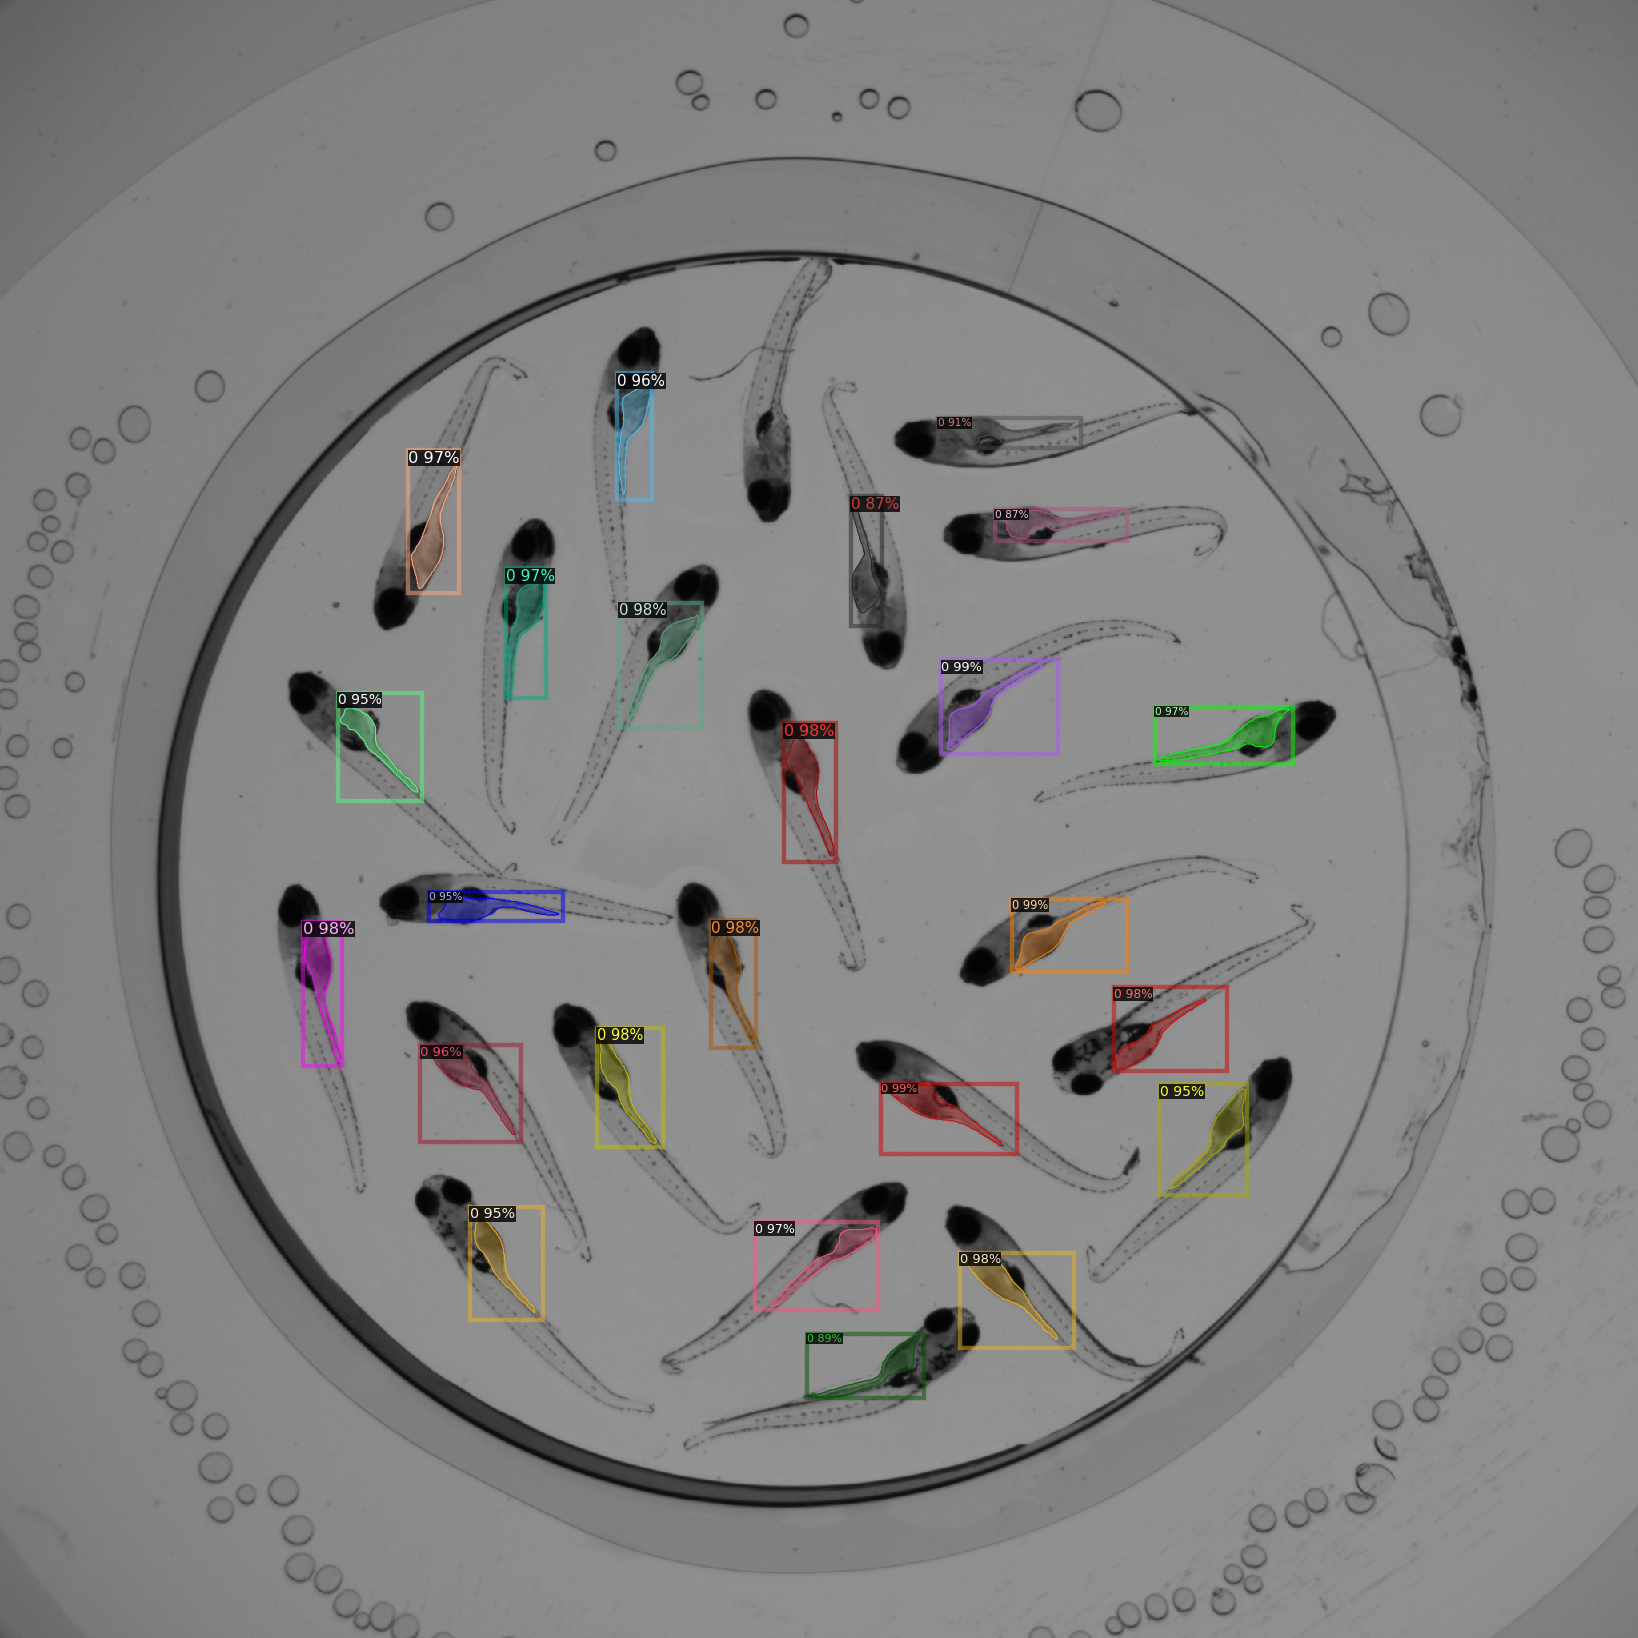

In [ ]:
from PIL import Image

im = cv2.imread("/content/drive/MyDrive/betaine_1mM001--C00.tif")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=gut_metadata, 
                scale=0.8, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(v.get_image()[:, :, ::-1])

To check prediction masks of all images in folder, not recommended if a lot of images

In [ ]:
directory = ""

for filename in os.listdir(directory):
    if filename.endswith("tif"):
        im = cv2.imread(os.path.join(directory,filename))
        outputs = predictor(im)
        v = Visualizer(im[:, :, ::-1],
                metadata=gut_metadata, 
                scale=0.8, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
        )
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

        cv2_imshow(v.get_image()[:, :, ::-1])

# Fluorescence analysis

nchannels = 1 for individual feeding, 2 for preference

Fill in your channel names (eg. Cy5, RFP, mCherry) in same case as your folder names

maindir MUST be in google drive

results will be saved as a csv file in your maindir, rename however you like

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

################################################################################
#EDIT THIS PART ONLY

nchannels = 1
ch1name = "Cy5"
ch2name = "RFP" # leave it even if you dont have 2 channels, it does not affect
maindir = "" # directory where all the BFmask, Cy5 etc. are stored

################################################################################

BFmaskdir = os.path.join(maindir,"BFmask")

if nchannels == 1:
    ch1 = os.path.join(maindir,ch1name)
elif nchannels == 2:
    ch1 = os.path.join(maindir,ch1name)
    ch2 = os.path.join(maindir,ch2name)

results_dict = {}

for im in os.listdir(BFmaskdir):
    if im.endswith('png'):

        maskim = cv.imread(os.path.join(BFmaskdir,im),0)
        if len(maskim.shape) != 2:
            raise Exception("mask image has more than 1 channel")

        imname = im.split('--')[0]
        ch1_im_name = [filename for filename in os.listdir(ch1) if filename.startswith(imname)][0]
        intensityim_ch1 = cv.imread(os.path.join(ch1,ch1_im_name),-1)
        if intensityim_ch1.dtype != 'uint16':
            #raise Exception('Channel 1 image is not 16 bit')
            print('Channel 1 image is not 16 bit')
        
        if nchannels == 2:
            ch2_im_name = [filename for filename in os.listdir(ch2) if filename.startswith(imname)][0]
            intensityim_ch2 = cv.imread(os.path.join(ch2,ch2_im_name),-1)
            if intensityim_ch2.dtype != 'uint16':
                #raise Exception('Channel 2 image is not 16 bit')
                print('Channel 2 image is not 16 bit')

        labeledim = cv.connectedComponentsWithStats(maskim)
        fishnum = labeledim[0] - 1 # subtract 1 for background

        ch1_mean_list = []
        ch2_mean_list = []
        for i in range(1,fishnum + 1):
            gutmask = labeledim[1] == i
            gutintensity_ch1 = gutmask * intensityim_ch1
            ch1mean_temp = gutintensity_ch1[gutintensity_ch1!=0].mean()
            ch1_mean_list.append(ch1mean_temp)

            if nchannels == 2:
                gutintensity_ch2 = gutmask * intensityim_ch2
                ch2mean_temp = gutintensity_ch2[gutintensity_ch2!=0].mean()
                ch2_mean_list.append(ch2mean_temp)
        
        if nchannels == 1:
            results_dict[imname] = ch1_mean_list
        elif nchannels == 2:
            results_dict[imname+'_' + ch1name] = ch1_mean_list
            results_dict[imname+'_' + ch2name] = ch2_mean_list

results_df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in results_dict.items()]))
results_df.to_csv(os.path.join(maindir,'results.csv'),index=False)

